# Few-Shot Adaptation Analysis

This notebook analyzes locked experimental CSV outputs and generates publication-quality plots.
No experiments are re-run.

## Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for conference-ready figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("Libraries imported successfully")

Libraries imported successfully


## Define File Structure and Algorithm Mapping

In [2]:
# Base directory
BASE_DIR = Path(r'e:\plot_CSVs')

# Seeds to process
SEEDS = ['Seed42', 'Seed123', 'Seed456']

# Algorithm mapping: (CSV filename pattern, Display name, Color, Marker)
ALGORITHMS = [
    ('maml_RL_metrics', 'MAML-RL', '#1f77b4', 'o'),
    ('maml-encoder_(anil)_metrics', 'MAML-ANIL', '#ff7f0e', 's'),
    ('maml-encoder_(full-maml)_metrics', 'Full-MAML', '#2ca02c', '^'),
    ('subject-conditioned_new_metrics', 'Subject-Conditioned Meta-Learning', '#d62728', 'D'),
    ('pooled_ppo_+_finetune_metrics', 'Pooled PPO + Finetune', '#9467bd', 'v'),
    ('single-subject_ppo_metrics', 'Single-Subject PPO', '#8c564b', 'p'),
    ('supervised_baseline_metrics', 'Supervised Baseline (LOSO)', '#e377c2', '*')
]

print(f"Processing seeds: {SEEDS}")
print(f"Analyzing {len(ALGORITHMS)} algorithms")

Processing seeds: ['Seed42', 'Seed123', 'Seed456']
Analyzing 7 algorithms


## Data Loading and Validation Functions

In [9]:
def load_algorithm_data(seed, csv_pattern):
    """
    Load CSV data for a specific algorithm and seed.
    Returns DataFrame with K, Mean_Accuracy, Min_Accuracy, Max_Accuracy.
    """
    seed_dir = BASE_DIR / seed
    
    # Find matching CSV file
    matching_files = list(seed_dir.glob(f'*{csv_pattern}.csv'))
    
    if len(matching_files) == 0:
        raise FileNotFoundError(f"No CSV found for pattern '{csv_pattern}' in {seed}")
    if len(matching_files) > 1:
        raise ValueError(f"Multiple CSVs found for pattern '{csv_pattern}' in {seed}")
    
    csv_path = matching_files[0]
    df = pd.read_csv(csv_path)
    
    # Detect column names (handle variations)
    k_col = [c for c in df.columns if c.lower() == 'k'][0]
    mean_cols = [c for c in df.columns if 'mean' in c.lower()]
    min_cols = [c for c in df.columns if 'min' in c.lower()]
    max_cols = [c for c in df.columns if 'max' in c.lower()]
    std_cols = [c for c in df.columns if 'std' in c.lower()]
    
    # Filter out 'Method' if present
    mean_cols = [c for c in mean_cols if 'method' not in c.lower()]
    min_cols = [c for c in min_cols if 'method' not in c.lower()]
    max_cols = [c for c in max_cols if 'method' not in c.lower()]
    std_cols = [c for c in std_cols if 'method' not in c.lower()]
    
    if not mean_cols:
        raise ValueError(f"Mean column not found in {csv_path}")
    
    # Check if Min/Max exist, otherwise compute from Mean ± Std
    if min_cols and max_cols:
        # Use existing Min/Max
        result = pd.DataFrame({
            'K': df[k_col],
            'Mean_Accuracy': df[mean_cols[0]],
            'Min_Accuracy': df[min_cols[0]],
            'Max_Accuracy': df[max_cols[0]]
        })
    elif std_cols:
        # Compute Min/Max from Mean ± Std (as approximation)
        # Use Mean ± 2*Std for a reasonable range
        print(f"Note: {csv_path.name} lacks Min/Max columns, using Mean ± 2*Std as approximation")
        result = pd.DataFrame({
            'K': df[k_col],
            'Mean_Accuracy': df[mean_cols[0]],
            'Min_Accuracy': df[mean_cols[0]] - 2 * df[std_cols[0]],
            'Max_Accuracy': df[mean_cols[0]] + 2 * df[std_cols[0]]
        })
        # Ensure Min/Max are within valid bounds [0, 1] or [0, 100]
        result['Min_Accuracy'] = result['Min_Accuracy'].clip(lower=0)
        if result['Mean_Accuracy'].max() <= 1.0:
            result['Max_Accuracy'] = result['Max_Accuracy'].clip(upper=1.0)
        else:
            result['Max_Accuracy'] = result['Max_Accuracy'].clip(upper=100.0)
    else:
        raise ValueError(f"No Min/Max or Std columns found in {csv_path}")
    
    # Convert to percentage if values are in [0, 1] range
    if result['Mean_Accuracy'].max() <= 1.0:
        result['Mean_Accuracy'] *= 100
        result['Min_Accuracy'] *= 100
        result['Max_Accuracy'] *= 100
    
    return result.sort_values('K')


def validate_and_display_data(seed, algorithms):
    """
    Load all algorithms for a seed and display validation table.
    Returns dictionary of {algorithm_name: DataFrame}.
    """
    print(f"\n{'='*80}")
    print(f"VALIDATION FOR {seed.upper()}")
    print(f"{'='*80}")
    
    data_dict = {}
    validation_rows = []
    
    for csv_pattern, algo_name, _, _ in algorithms:
        try:
            df = load_algorithm_data(seed, csv_pattern)
            data_dict[algo_name] = df
            
            # Add rows to validation table
            for _, row in df.iterrows():
                validation_rows.append({
                    'Algorithm': algo_name,
                    'K': int(row['K']),
                    'Mean': f"{row['Mean_Accuracy']:.2f}",
                    'Min': f"{row['Min_Accuracy']:.2f}",
                    'Max': f"{row['Max_Accuracy']:.2f}"
                })
        except Exception as e:
            print(f"ERROR loading {algo_name}: {e}")
            continue
    
    # Display validation table
    validation_df = pd.DataFrame(validation_rows)
    print("\n" + validation_df.to_string(index=False))
    
    # Validation checks
    print(f"\n{'─'*80}")
    print("VALIDATION CHECKS:")
    
    if 'MAML-RL' in data_dict:
        maml_rl_mean = data_dict['MAML-RL']['Mean_Accuracy'].mean()
        print(f"✓ MAML-RL average accuracy: {maml_rl_mean:.2f}% (should be near chance/flat)")
    
    if 'Subject-Conditioned Meta-Learning' in data_dict:
        sc_mean = data_dict['Subject-Conditioned Meta-Learning']['Mean_Accuracy'].mean()
        print(f"✓ Subject-Conditioned average accuracy: {sc_mean:.2f}% (should be highest/near highest)")
    
    print(f"✓ Loaded {len(data_dict)} algorithms successfully")
    print(f"{'='*80}\n")
    
    return data_dict

print("Data loading functions defined")

Data loading functions defined


## TASK 1: Generate Adaptation Curve Plots (Per Seed)

In [7]:
def plot_adaptation_curve(seed, data_dict, algorithms, save_path):
    """
    Create adaptation curve plot for a single seed.
    Shows mean accuracy with min/max shaded region for all algorithms.
    """
    if not data_dict:
        print(f"ERROR: No data available for {seed}. Skipping plot generation.")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for csv_pattern, algo_name, color, marker in algorithms:
        if algo_name not in data_dict:
            print(f"Warning: {algo_name} not found in data")
            continue
        
        df = data_dict[algo_name]
        
        # Plot mean line
        ax.plot(df['K'], df['Mean_Accuracy'], 
                label=algo_name, color=color, marker=marker,
                linewidth=2, markersize=8, markeredgewidth=0.5, 
                markeredgecolor='white')
        
        # Plot shaded region (min to max)
        ax.fill_between(df['K'], df['Min_Accuracy'], df['Max_Accuracy'],
                        color=color, alpha=0.15)
    
    # Formatting
    ax.set_xlabel('K (Number of Support Shots)', fontweight='bold')
    ax.set_ylabel('Classification Accuracy (%)', fontweight='bold')
    
    # Extract seed number for title
    seed_num = seed.replace('Seed', '')
    ax.set_title(f'Few-Shot Adaptation Performance (Seed {seed_num})', 
                fontweight='bold', pad=15)
    
    # Legend
    ax.legend(loc='best', framealpha=0.95, edgecolor='gray')
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Set x-axis to show integer K values
    k_values = sorted(data_dict[list(data_dict.keys())[0]]['K'].unique())
    ax.set_xticks(k_values)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}")
    plt.show()
    plt.close()

print("Adaptation curve plotting function defined")

Adaptation curve plotting function defined


### Generate Adaptation Curves for All Seeds


VALIDATION FOR SEED42
Note: Seed42_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed42_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

                        Algorithm  K  Mean   Min   Max
                          MAML-RL  5 48.70 27.55 88.19
                          MAML-RL 10 48.81 29.20 87.95
                          MAML-RL 20 48.32 28.92 88.28
                          MAML-RL 50 48.50 30.77 87.08
                        MAML-ANIL  5 54.65  9.18 85.04
                        MAML-ANIL 10 55.37  9.68 85.25
                        MAML-ANIL 20 55.41  8.43 84.82
                        MAML-ANIL 50 55.75  9.43 89.02
                        Full-MAML  5 55.11  9.18 85.04
                        Full-MAML 10 55.81  9.68 85.25
                        Full-MAML 20 56.27  8.43 85.71
                        Full-MAML 50 56.57  9.43 90.24
Subject-Conditioned Meta-Learning  5 69.38 43.60 

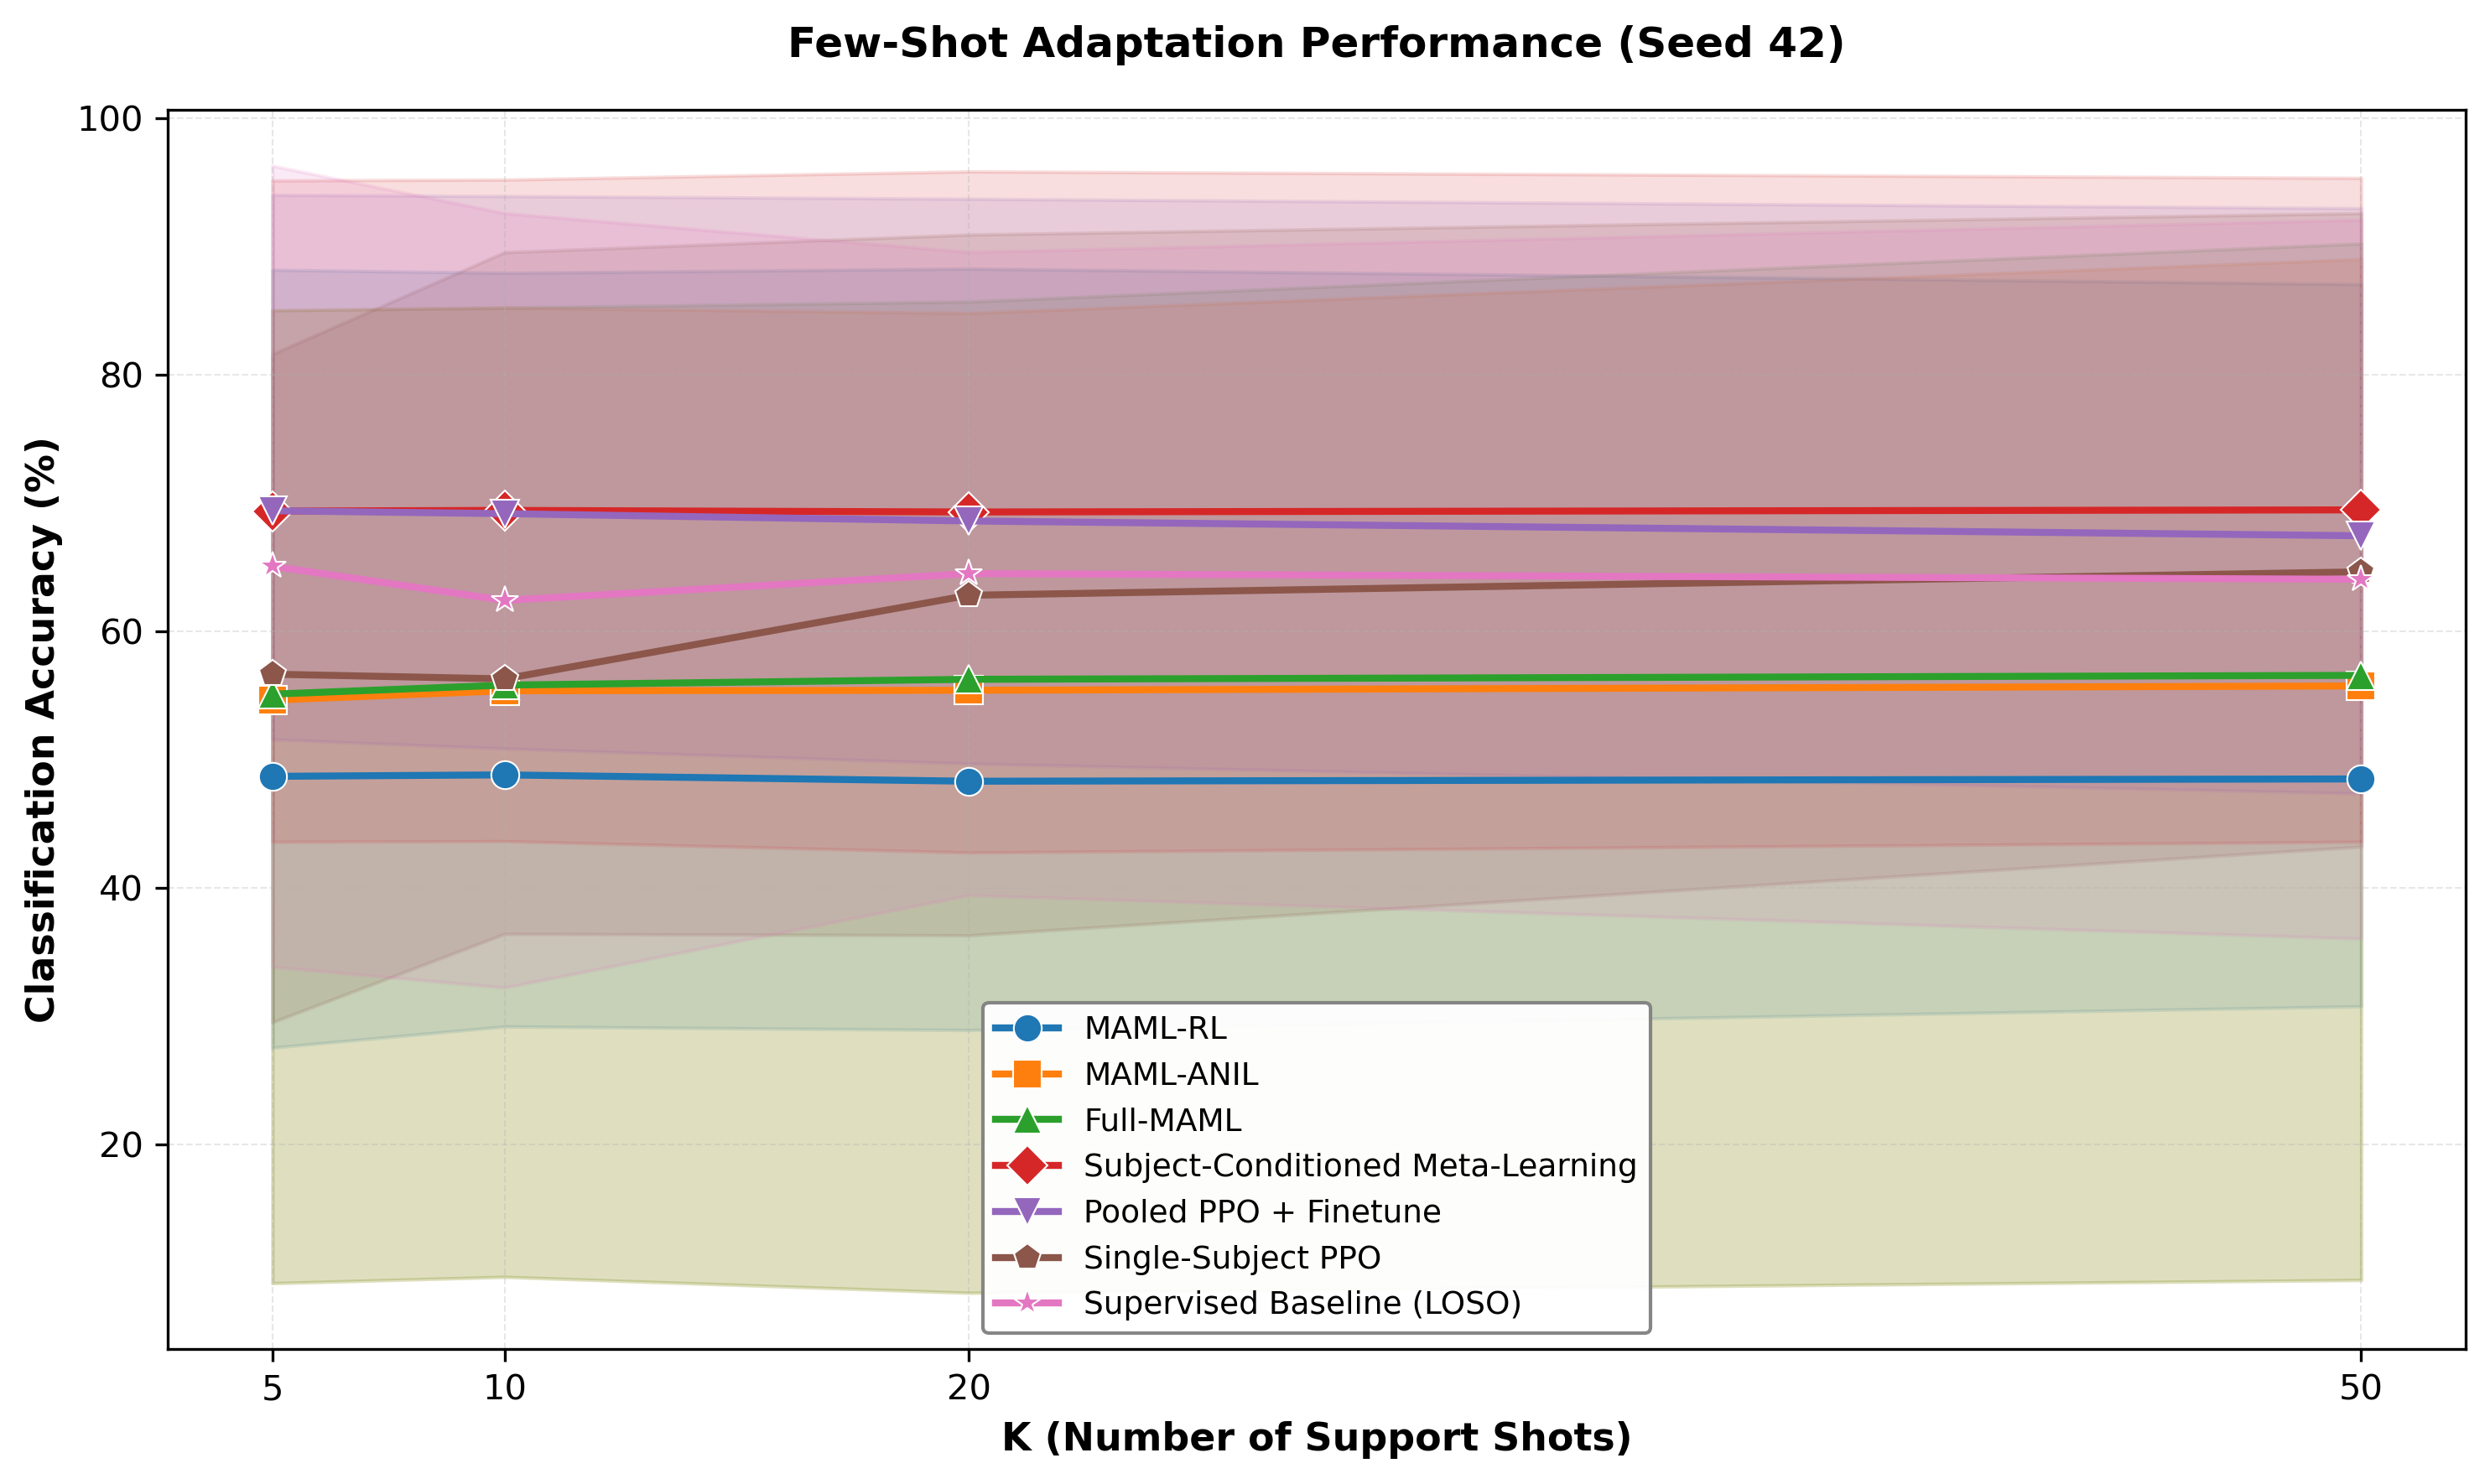


VALIDATION FOR SEED123
Note: Seed123_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed123_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

                        Algorithm  K  Mean   Min   Max
                          MAML-RL  5 50.01 11.42 90.73
                          MAML-RL 10 49.19 11.24 90.24
                          MAML-RL 20 49.25 11.72 90.24
                          MAML-RL 50 50.16 12.44 89.49
                        MAML-ANIL  5 60.71 33.65 93.71
                        MAML-ANIL 10 61.07 33.55 93.94
                        MAML-ANIL 20 60.78 33.33 93.73
                        MAML-ANIL 50 61.33 33.70 92.61
                        Full-MAML  5 61.18 33.65 93.71
                        Full-MAML 10 61.54 33.87 93.94
                        Full-MAML 20 61.31 33.66 93.73
                        Full-MAML 50 61.81 33.70 92.61
Subject-Conditioned Meta-Learning  5 69.84 43.

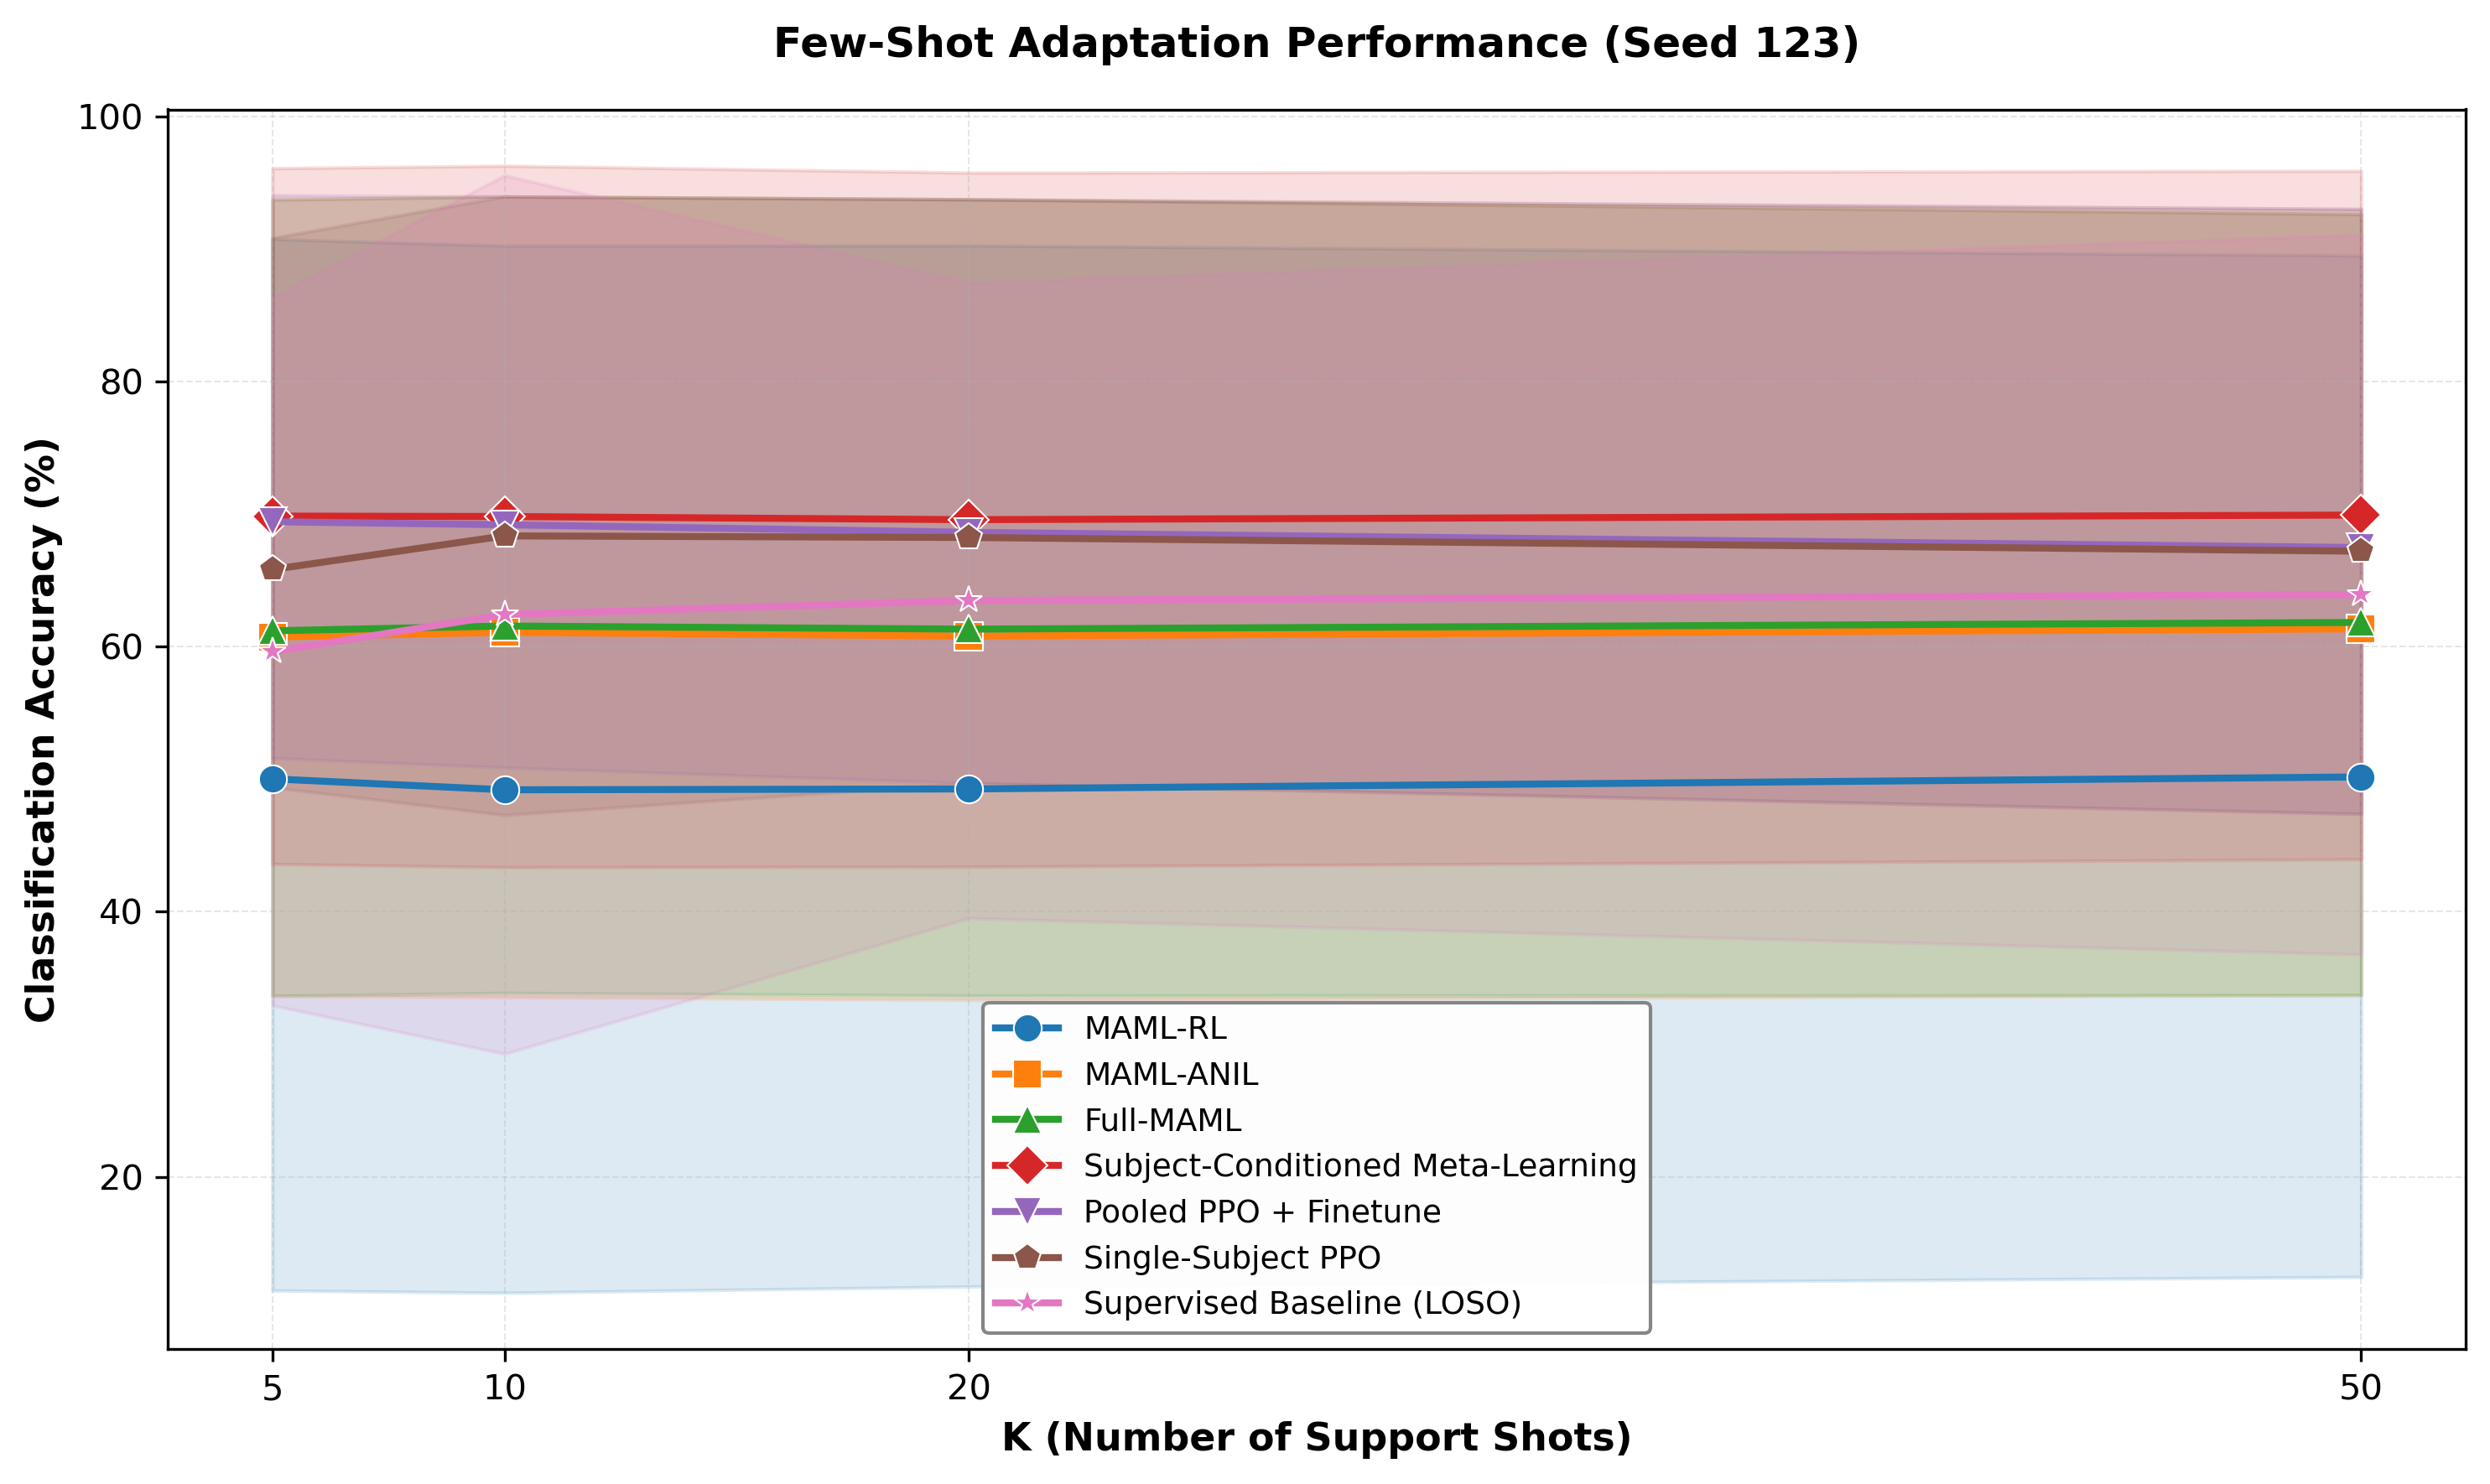


VALIDATION FOR SEED456
Note: Seed456_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed456_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

                        Algorithm  K  Mean   Min   Max
                          MAML-RL  5 51.33 11.42 92.05
                          MAML-RL 10 51.33 11.24 91.92
                          MAML-RL 20 51.25 11.72 90.59
                          MAML-RL 50 51.03 12.44 89.88
                        MAML-ANIL  5 54.84 12.20 93.71
                        MAML-ANIL 10 54.65 12.05 93.60
                        MAML-ANIL 20 55.26 12.13 93.73
                        MAML-ANIL 50 55.04 11.00 93.00
                        Full-MAML  5 55.55 12.99 93.71
                        Full-MAML 10 55.38 11.65 93.60
                        Full-MAML 20 55.81 12.13 93.73
                        Full-MAML 50 55.40 11.00 93.00
Subject-Conditioned Meta-Learning  5 69.32 43.

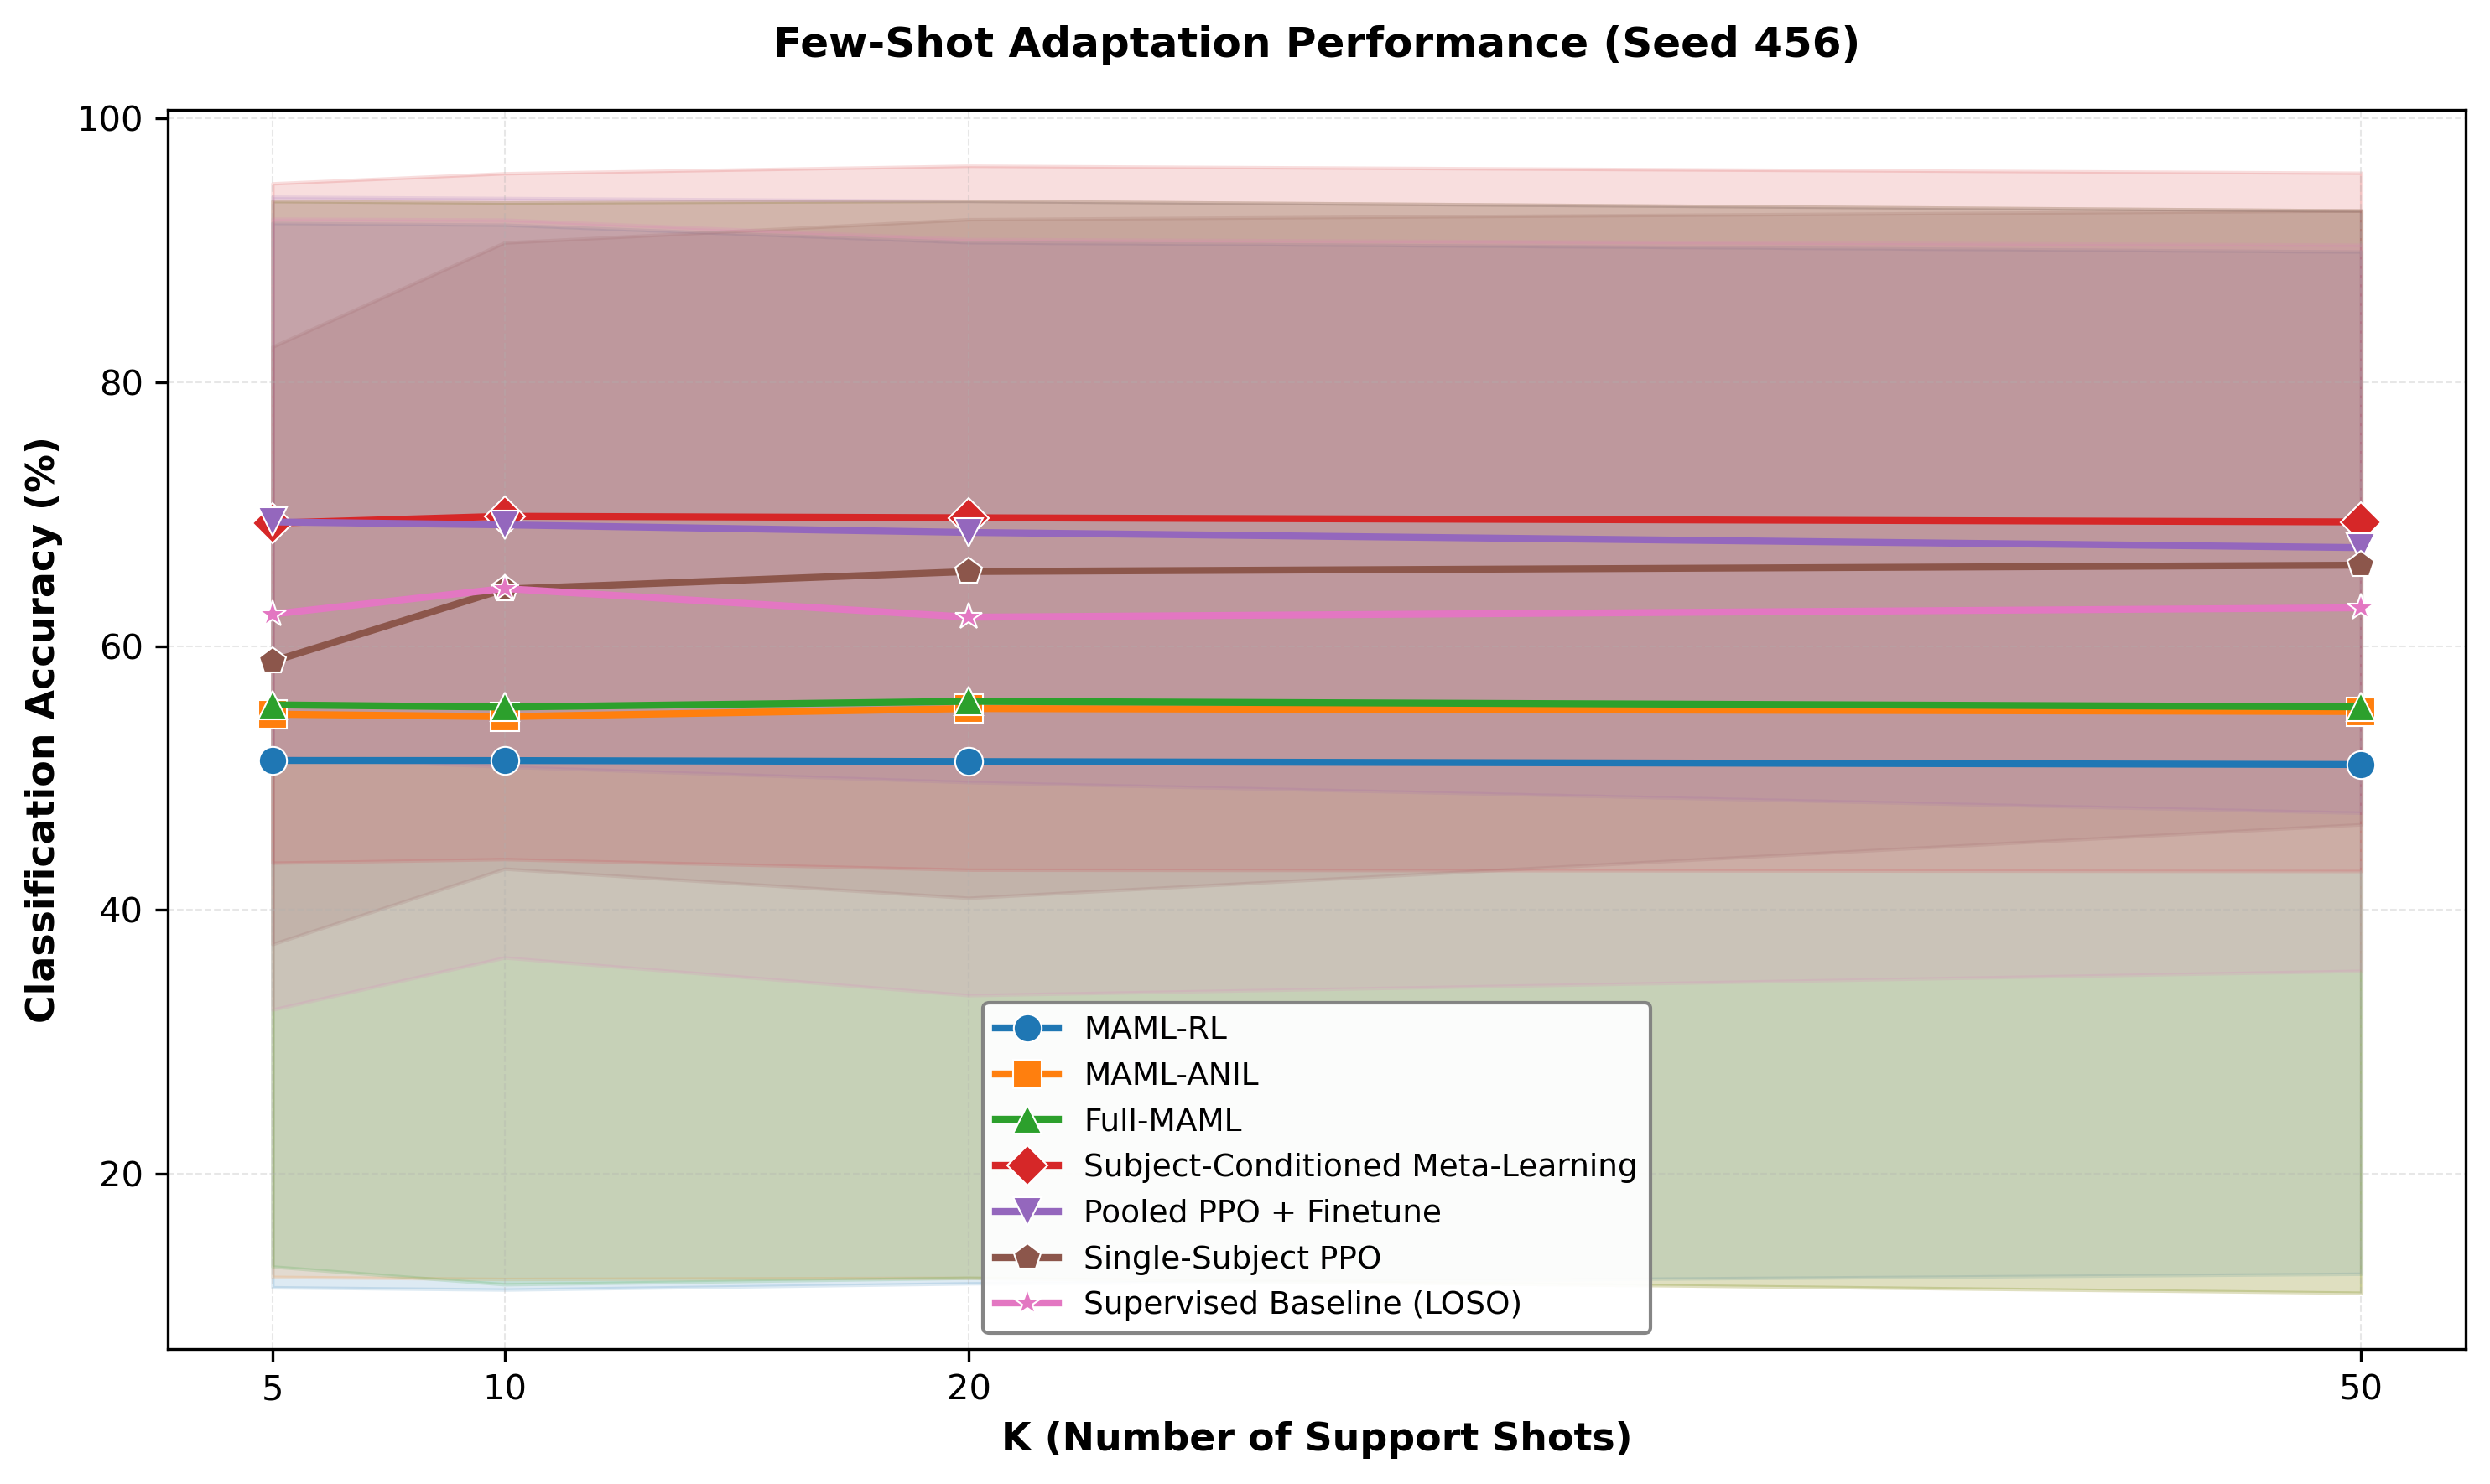


TASK 1 COMPLETE: All adaptation curve plots generated


In [10]:
# Generate adaptation curve for each seed
for seed in SEEDS:
    # Load and validate data
    data_dict = validate_and_display_data(seed, ALGORITHMS)
    
    # Generate plot
    save_path = BASE_DIR / f'adaptation_curve_{seed.lower()}.png'
    plot_adaptation_curve(seed, data_dict, ALGORITHMS, save_path)

print("\n" + "="*80)
print("TASK 1 COMPLETE: All adaptation curve plots generated")
print("="*80)

## TASK 2: Generate Final Accuracy Bar Plots (Per Seed)

In [11]:
def compute_summary_statistics(data_dict, k_values=[5, 10, 15, 20]):
    """
    Compute summary statistics for specified K values.
    Returns DataFrame with columns: Algorithm, Mean_of_Mean, Mean_of_Min, Mean_of_Max.
    """
    summary_rows = []
    
    for algo_name, df in data_dict.items():
        # Filter for specified K values
        df_filtered = df[df['K'].isin(k_values)]
        
        if len(df_filtered) == 0:
            print(f"Warning: No data for K={k_values} in {algo_name}")
            continue
        
        mean_of_mean = df_filtered['Mean_Accuracy'].mean()
        mean_of_min = df_filtered['Min_Accuracy'].mean()
        mean_of_max = df_filtered['Max_Accuracy'].mean()
        
        summary_rows.append({
            'Algorithm': algo_name,
            'Mean_of_Mean': mean_of_mean,
            'Mean_of_Min': mean_of_min,
            'Mean_of_Max': mean_of_max
        })
    
    return pd.DataFrame(summary_rows)


def plot_accuracy_comparison(seed, summary_df, algorithms, save_path, k_values=[5, 10, 15, 20]):
    """
    Create bar plot comparing all algorithms with error bars.
    Error bars represent [Mean - Mean(Min), Mean(Max) - Mean].
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create color map for consistent colors
    color_map = {name: color for _, name, color, _ in algorithms}
    
    # Prepare data in order of ALGORITHMS
    algo_order = [name for _, name, _, _ in algorithms]
    summary_df['Algorithm'] = pd.Categorical(summary_df['Algorithm'], 
                                             categories=algo_order, 
                                             ordered=True)
    summary_df = summary_df.sort_values('Algorithm')
    
    x_pos = np.arange(len(summary_df))
    
    # Calculate error bars
    lower_error = summary_df['Mean_of_Mean'] - summary_df['Mean_of_Min']
    upper_error = summary_df['Mean_of_Max'] - summary_df['Mean_of_Mean']
    error_bars = [lower_error.values, upper_error.values]
    
    # Get colors for each algorithm
    bar_colors = [color_map.get(algo, '#999999') for algo in summary_df['Algorithm']]
    
    # Create bars
    bars = ax.bar(x_pos, summary_df['Mean_of_Mean'], 
                  color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    # Add error bars
    ax.errorbar(x_pos, summary_df['Mean_of_Mean'], 
                yerr=error_bars, fmt='none', ecolor='black', 
                capsize=5, capthick=1.5, linewidth=1.5)
    
    # Annotate bars with values
    for i, (idx, row) in enumerate(summary_df.iterrows()):
        mean_val = row['Mean_of_Mean']
        range_lower = row['Mean_of_Min']
        range_upper = row['Mean_of_Max']
        
        # Add text annotation above bar
        ax.text(i, mean_val + (range_upper - mean_val) + 1.5, 
               f"{mean_val:.1f}%",
               ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # Formatting
    ax.set_xlabel('Method', fontweight='bold')
    ax.set_ylabel('Mean Classification Accuracy (%)', fontweight='bold')
    
    seed_num = seed.replace('Seed', '')
    k_range = f"{min(k_values)}–{max(k_values)}"
    ax.set_title(f'Accuracy Comparison Across Methods (Seed {seed_num}, K = {k_range})',
                fontweight='bold', pad=15)
    
    # X-axis labels (algorithm names)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(summary_df['Algorithm'], rotation=45, ha='right')
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {save_path}")
    plt.show()
    plt.close()

print("Accuracy comparison plotting functions defined")

Accuracy comparison plotting functions defined


### Generate Accuracy Comparison Plots for All Seeds


GENERATING BAR PLOT FOR SEED42
Note: Seed42_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed42_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

Summary Statistics (K = 5, 10, 15, 20):
                        Algorithm  Mean_of_Mean  Mean_of_Min  Mean_of_Max
                          MAML-RL     48.612002    28.554588    88.141767
                        MAML-ANIL     55.142954     9.098276    85.035566
                        Full-MAML     55.729773     9.098276    85.333186
Subject-Conditioned Meta-Learning     69.376489    43.334643    95.418336
            Pooled PPO + Finetune     69.067281    50.714194    93.902451
               Single-Subject PPO     58.594460    34.084305    87.378570
       Supervised Baseline (LOSO)     64.002290    35.171848    92.832732

✓ Saved: e:\plot_CSVs\accuracy_comparison_seed42.png


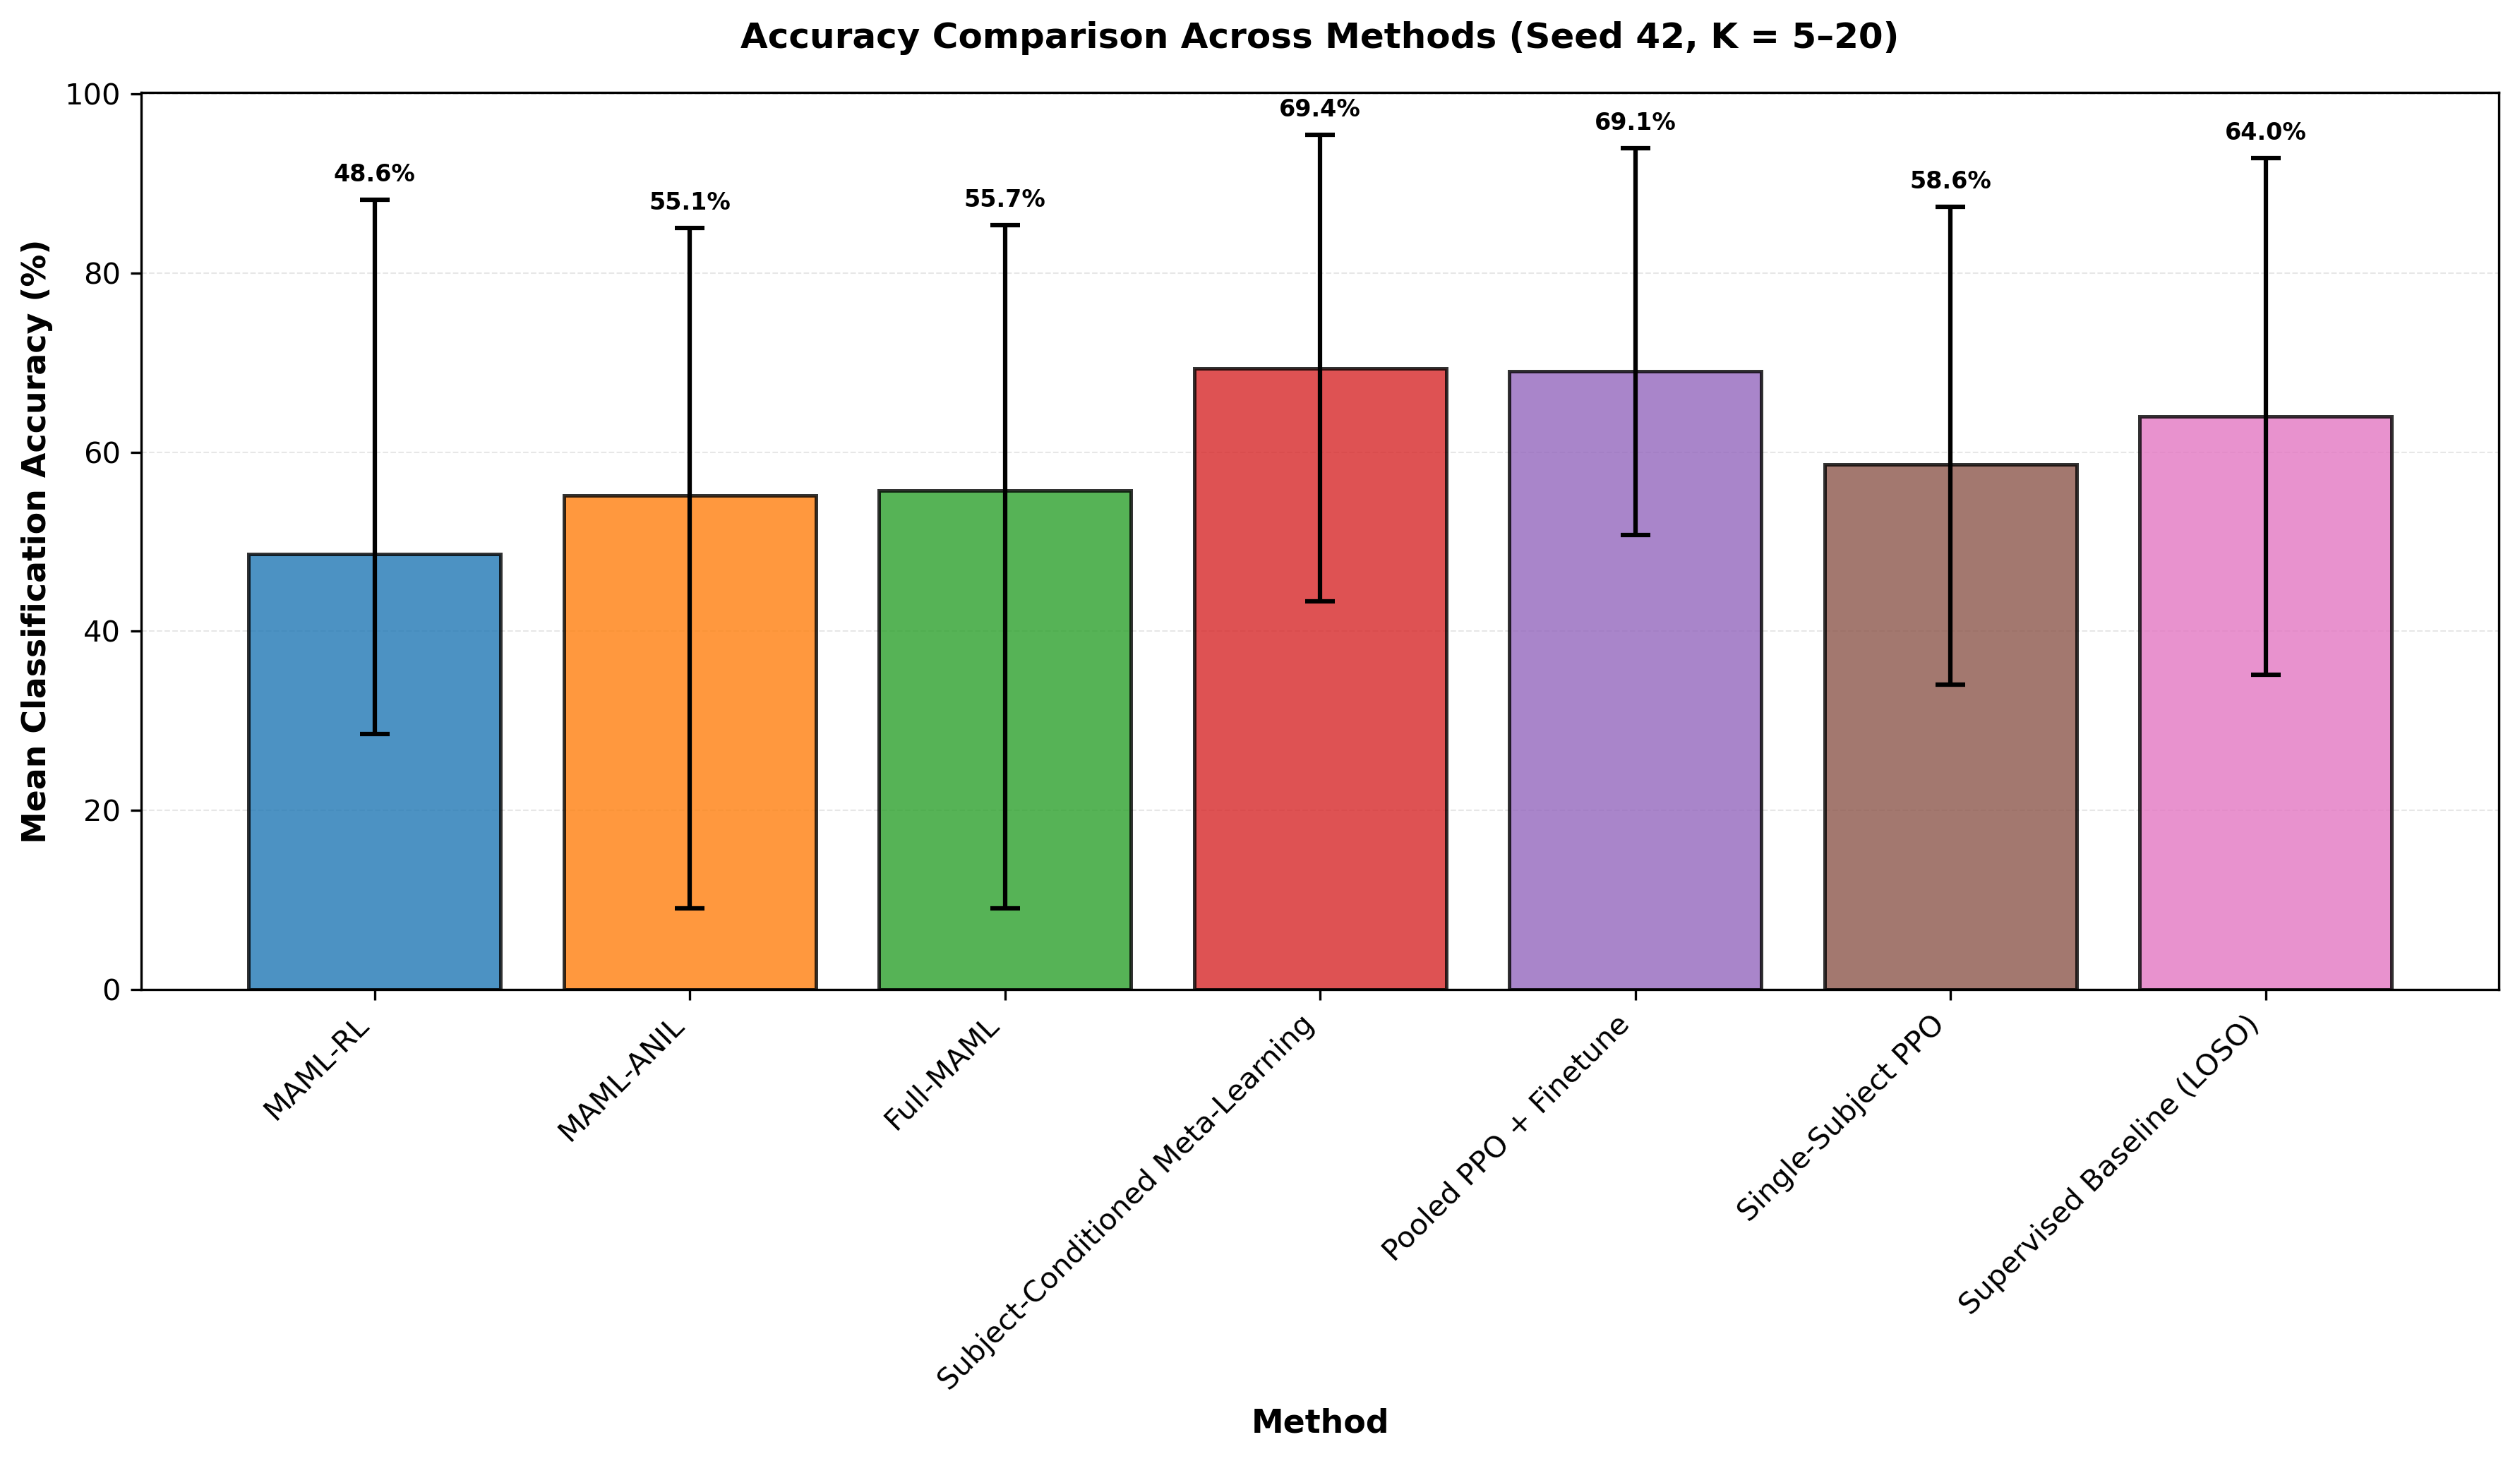


GENERATING BAR PLOT FOR SEED123
Note: Seed123_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed123_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

Summary Statistics (K = 5, 10, 15, 20):
                        Algorithm  Mean_of_Mean  Mean_of_Min  Mean_of_Max
                          MAML-RL     49.484321    11.459261    90.402690
                        MAML-ANIL     60.854197    33.509152    93.792077
                        Full-MAML     61.344061    33.725660    93.792077
Subject-Conditioned Meta-Learning     69.734811    43.442537    96.027085
            Pooled PPO + Finetune     69.067281    50.714194    93.902451
               Single-Subject PPO     67.457115    48.782889    92.827981
       Supervised Baseline (LOSO)     61.827126    33.896439    89.757812

✓ Saved: e:\plot_CSVs\accuracy_comparison_seed123.png


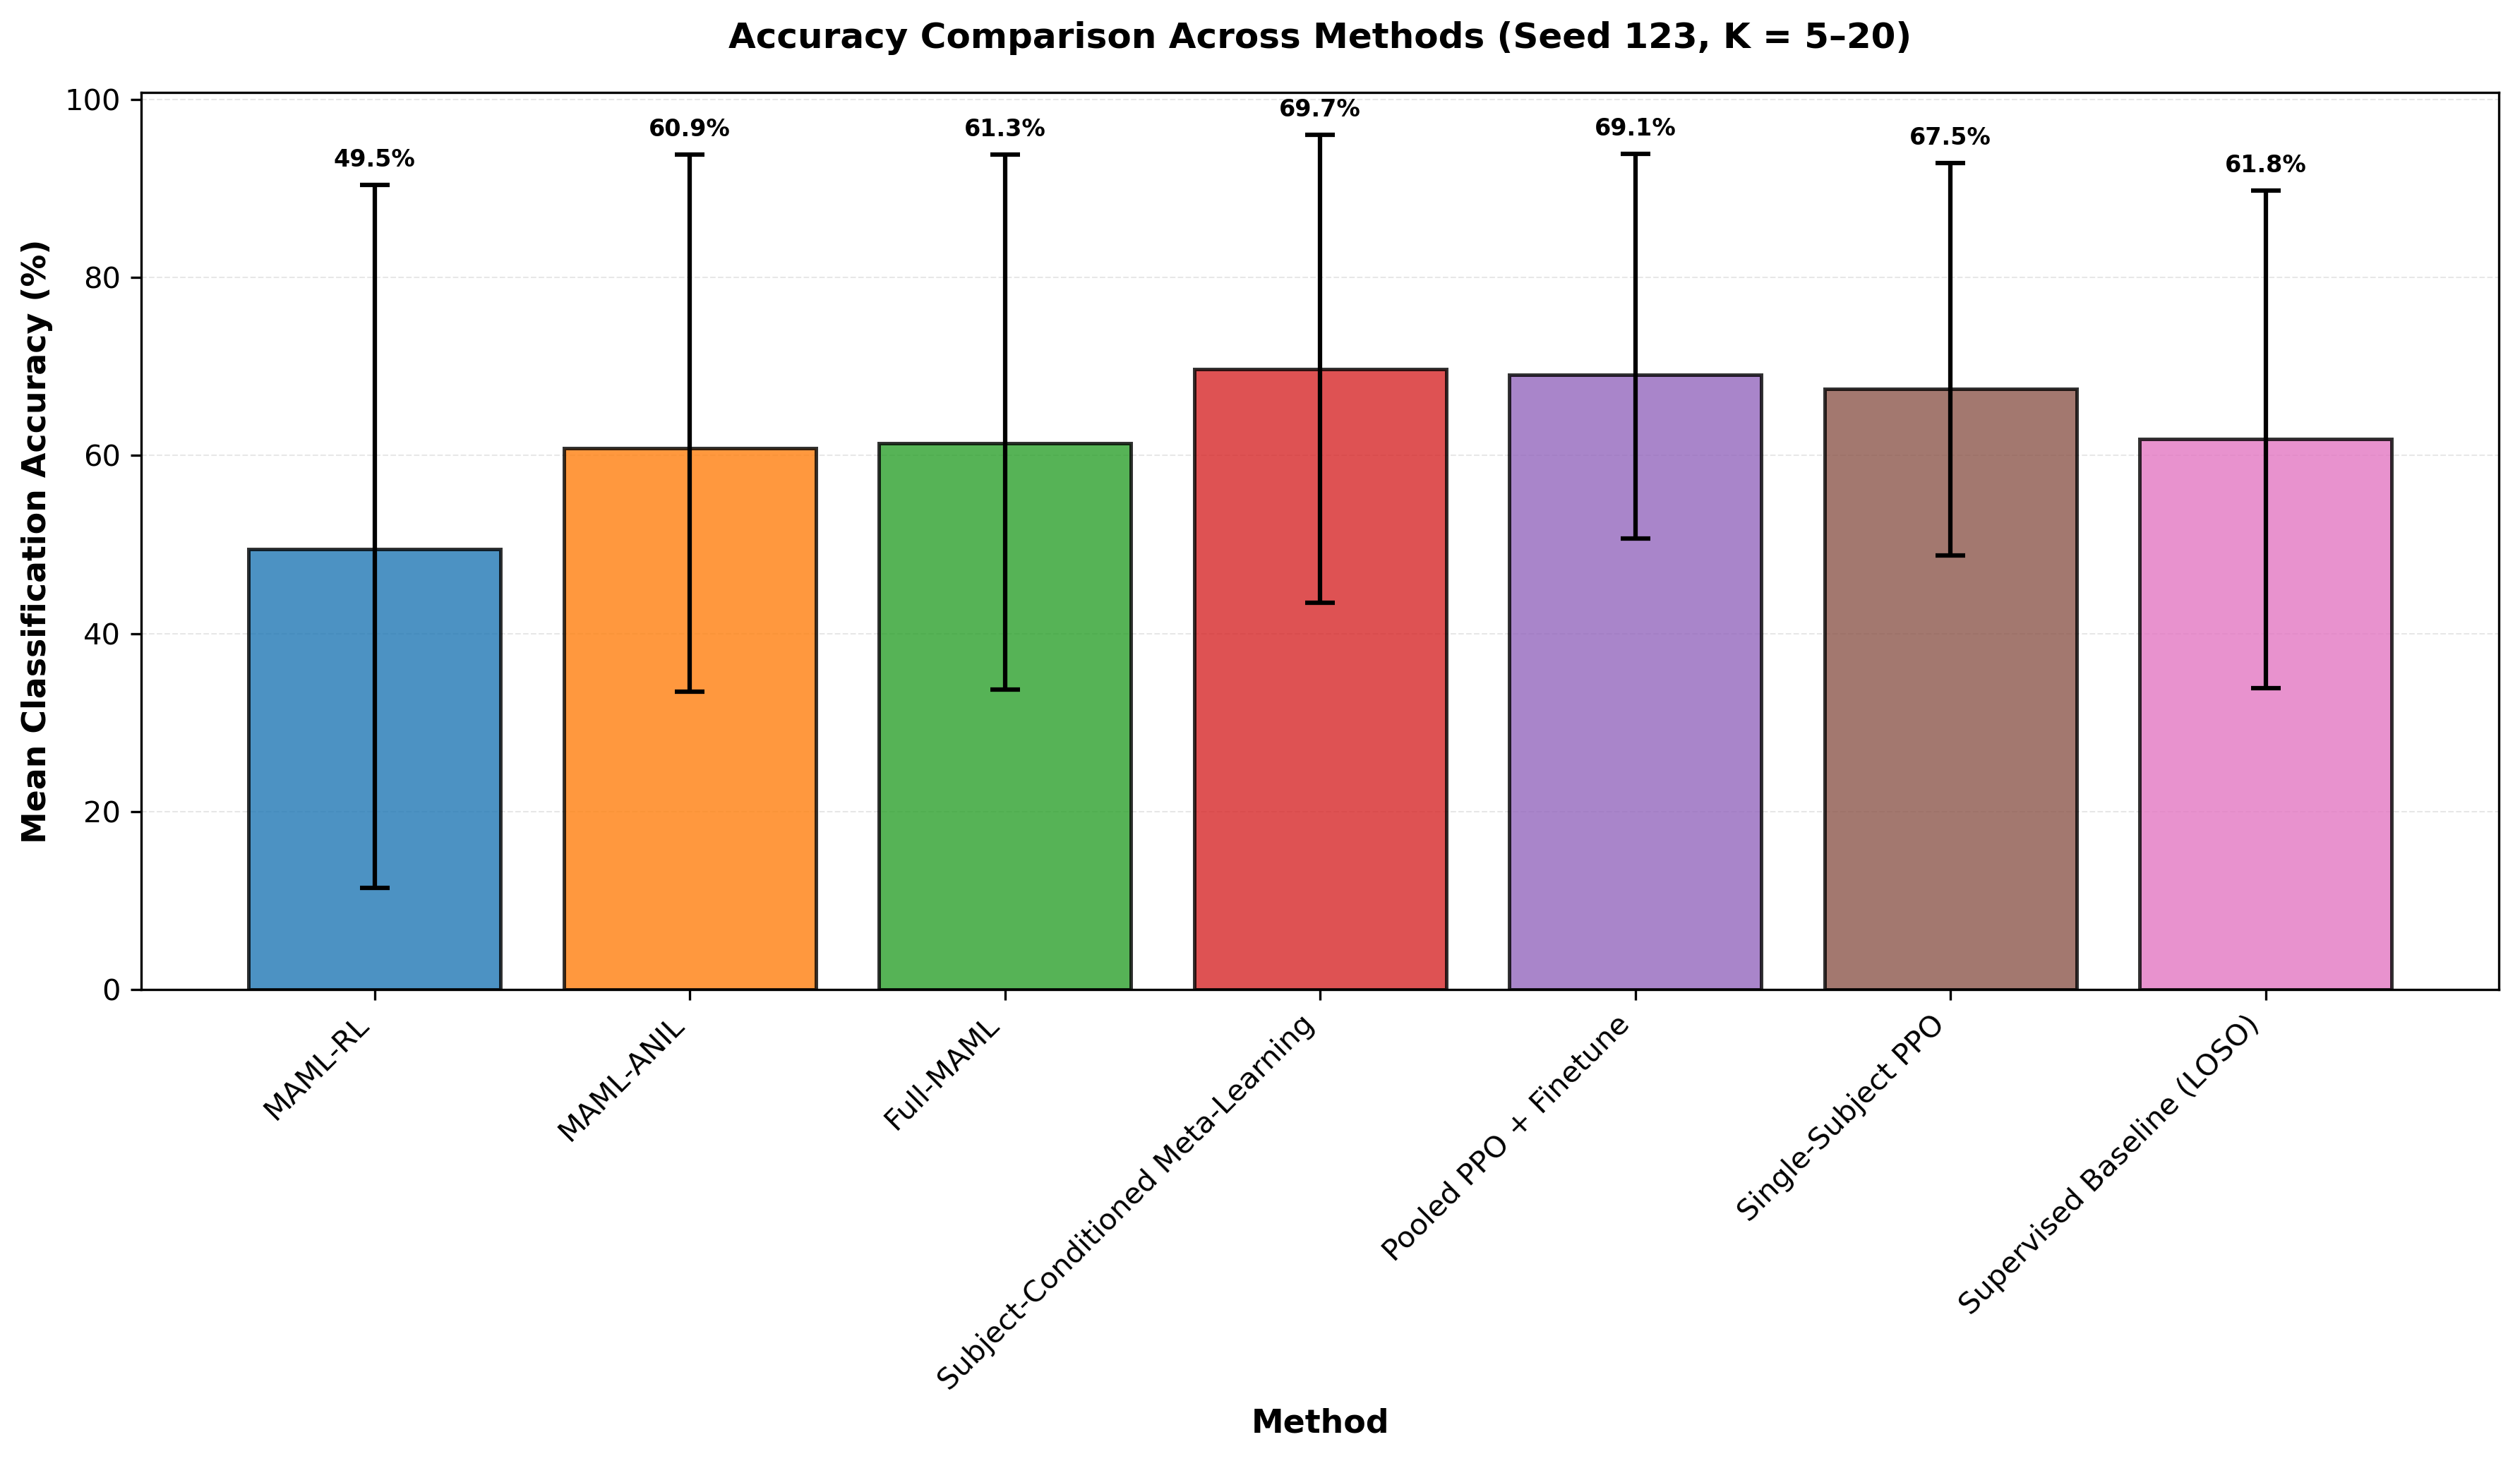


GENERATING BAR PLOT FOR SEED456
Note: Seed456_subject-conditioned_new_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation
Note: Seed456_supervised_baseline_metrics.csv lacks Min/Max columns, using Mean ± 2*Std as approximation

Summary Statistics (K = 5, 10, 15, 20):
                        Algorithm  Mean_of_Mean  Mean_of_Min  Mean_of_Max
                          MAML-RL     51.305313    11.459261    91.521502
                        MAML-ANIL     54.918730    12.128936    93.679843
                        Full-MAML     55.579828    12.257534    93.679843
Subject-Conditioned Meta-Learning     69.624951    43.498052    95.751851
            Pooled PPO + Finetune     69.067281    50.714194    93.902451
               Single-Subject PPO     62.933332    40.492155    88.528017
       Supervised Baseline (LOSO)     62.988419    34.137270    91.839568

✓ Saved: e:\plot_CSVs\accuracy_comparison_seed456.png


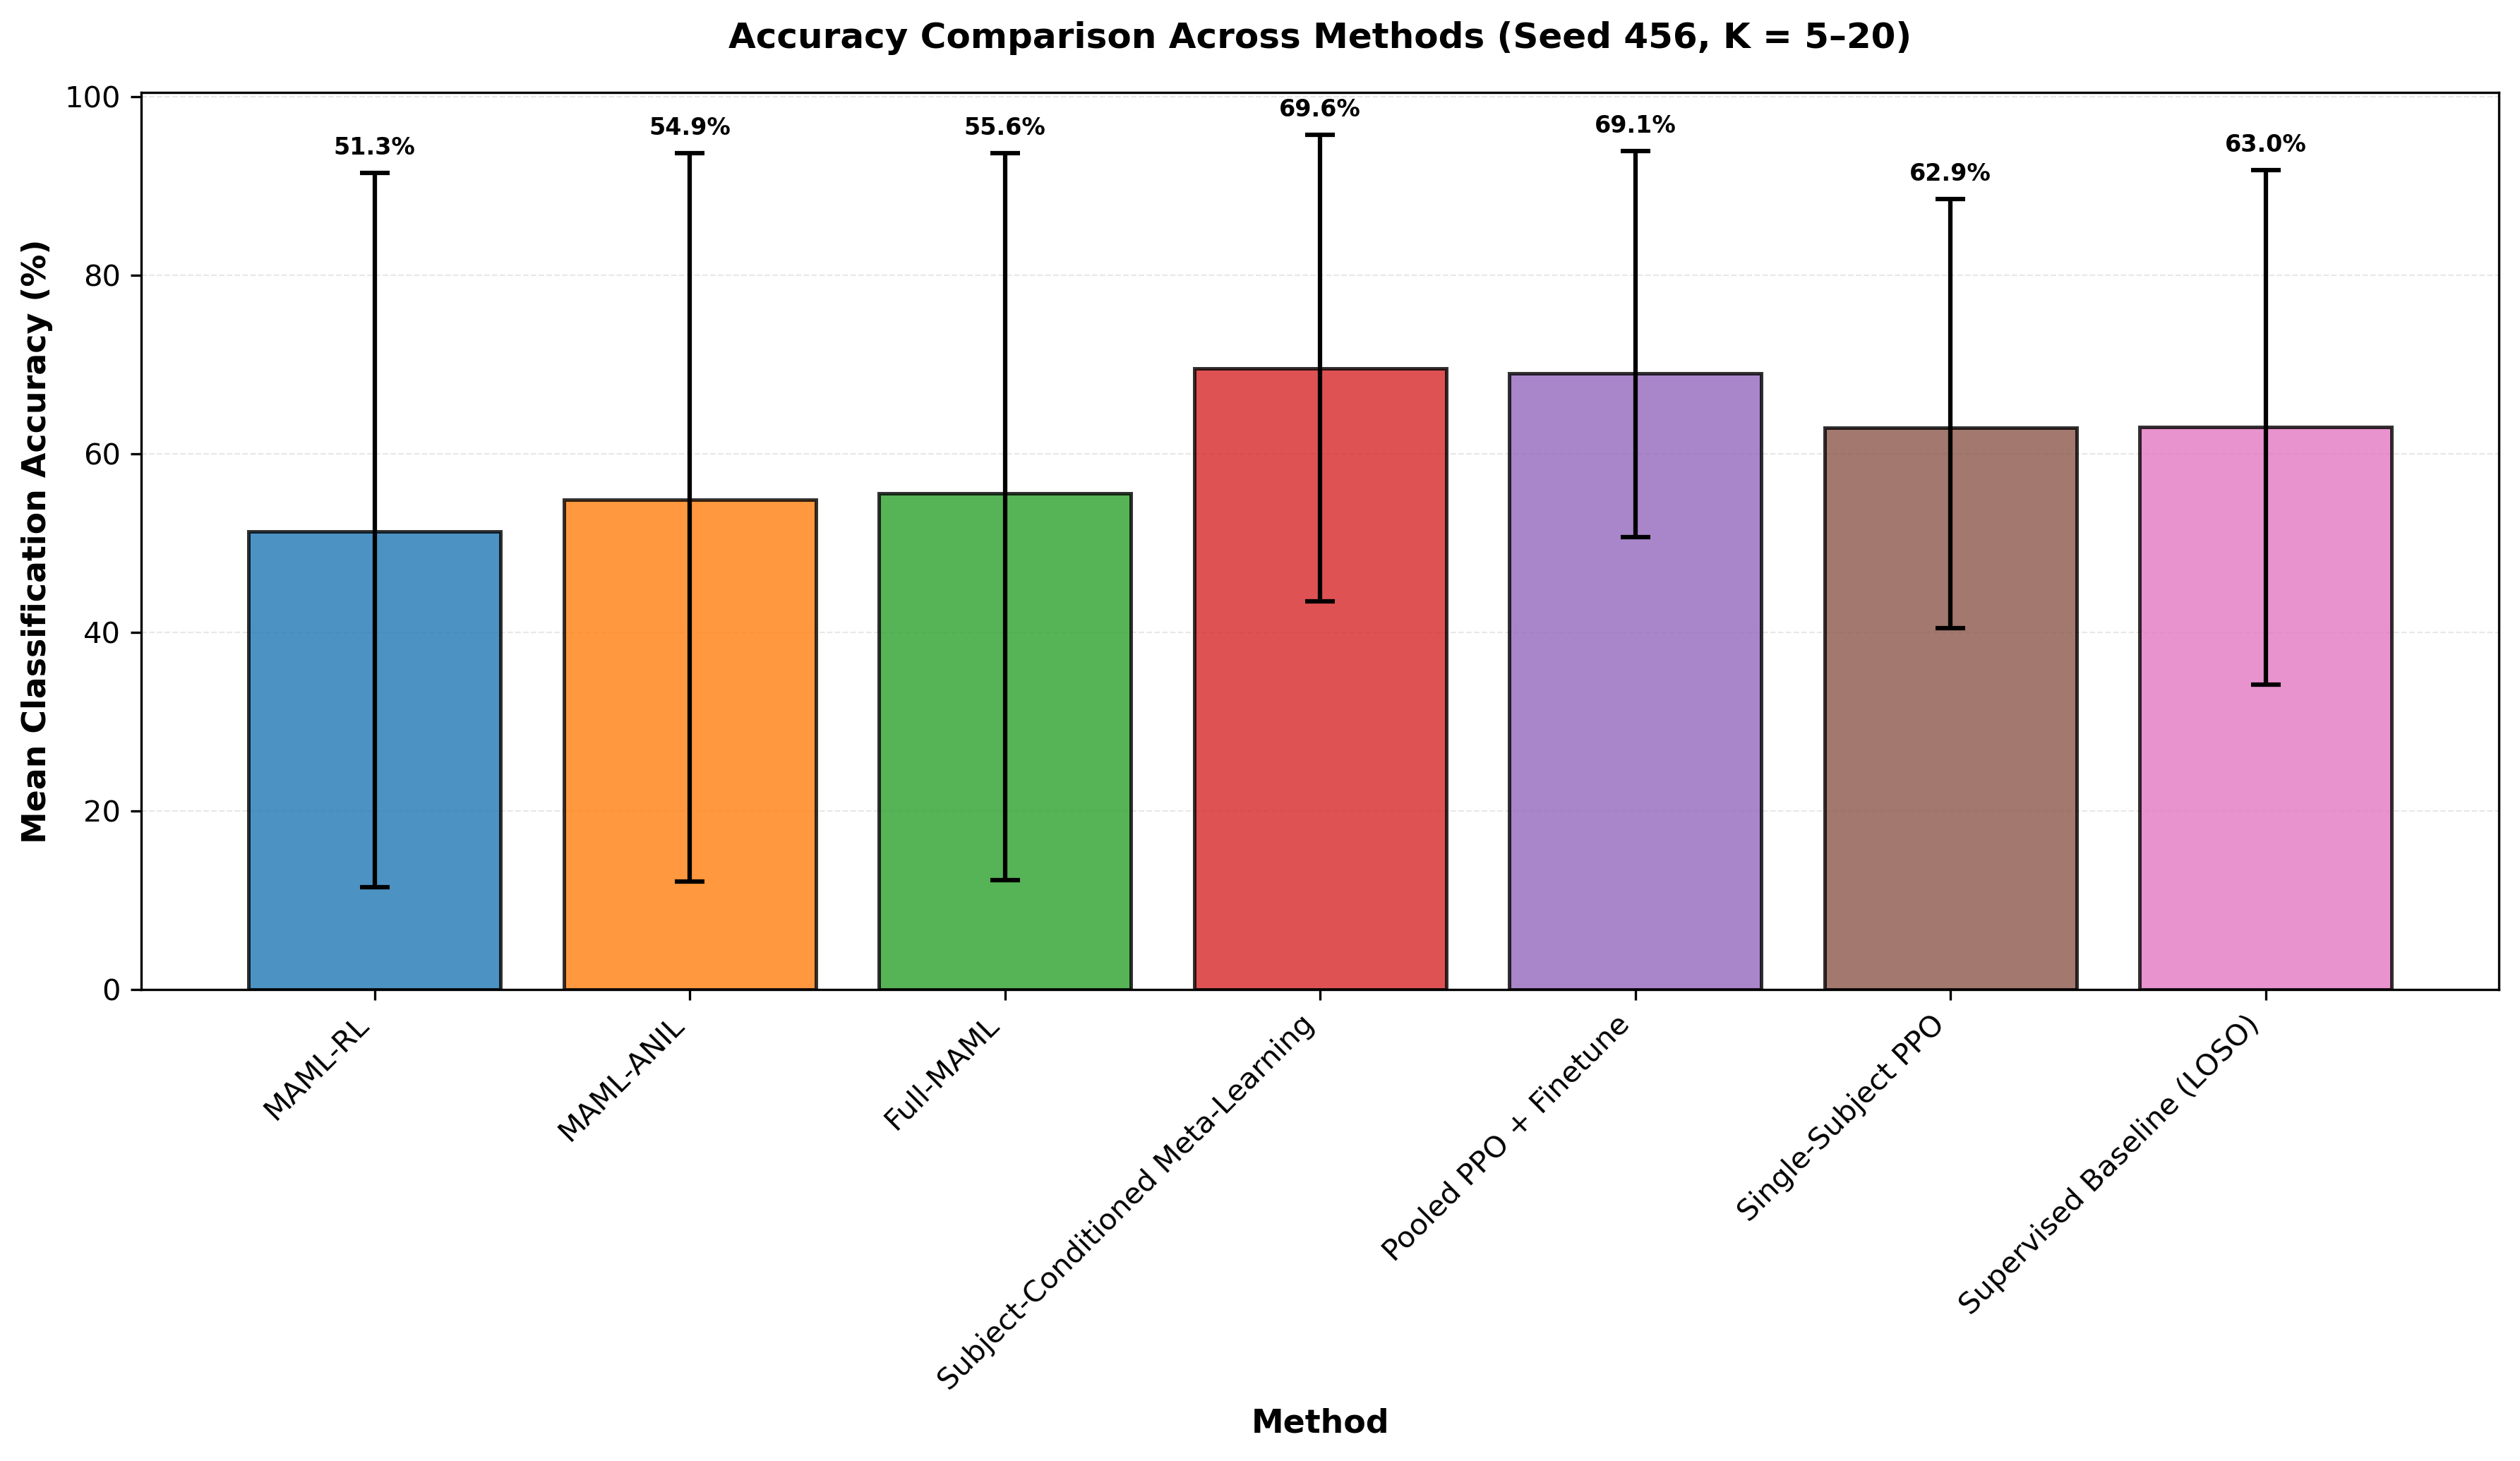


TASK 2 COMPLETE: All accuracy comparison plots generated


In [12]:
# Define K values to aggregate over
K_VALUES = [5, 10, 15, 20]

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"GENERATING BAR PLOT FOR {seed.upper()}")
    print(f"{'='*80}")
    
    # Load data (reuse from Task 1 or reload)
    data_dict = {}
    for csv_pattern, algo_name, _, _ in ALGORITHMS:
        try:
            df = load_algorithm_data(seed, csv_pattern)
            data_dict[algo_name] = df
        except Exception as e:
            print(f"Warning: Could not load {algo_name}: {e}")
    
    # Compute summary statistics
    summary_df = compute_summary_statistics(data_dict, K_VALUES)
    
    print("\nSummary Statistics (K = 5, 10, 15, 20):")
    print(summary_df.to_string(index=False))
    print()
    
    # Generate plot
    save_path = BASE_DIR / f'accuracy_comparison_{seed.lower()}.png'
    plot_accuracy_comparison(seed, summary_df, ALGORITHMS, save_path, K_VALUES)

print("\n" + "="*80)
print("TASK 2 COMPLETE: All accuracy comparison plots generated")
print("="*80)

## Summary

All plots have been generated successfully:

**Adaptation Curves (Task 1):**
- `adaptation_curve_seed42.png`
- `adaptation_curve_seed123.png`
- `adaptation_curve_seed456.png`

**Accuracy Comparisons (Task 2):**
- `accuracy_comparison_seed42.png`
- `accuracy_comparison_seed123.png`
- `accuracy_comparison_seed456.png`

All plots are conference-ready with DPI ≥ 300.